In [103]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
from sklearn import cluster

In [2]:
img_path = Path('Selfis/IMG_20240416_131204965_PORTRAIT.jpg')
img_path.exists()

True

In [3]:
def mostrar_imagen(img, ax = None, titulo=None):
    if ax is None:
        ax = plt.gca()
    ski.io.imshow(img, ax=ax)
    ax.axis('off')
    if titulo is not None:
        ax.set_title(titulo)

def mostrar_histograma(img, ax = None, n_barras=256):
    if ax is None:
        ax = plt.gca()
    ax.hist(img.ravel(), bins=n_barras, histtype='stepfilled', color='black')
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax.set_xlabel('Valor de píxel')
    ax.set_xlim(0, 1)
    ax.set_ylabel('Frecuencia')
    ax.spines[['top', 'right']].set_visible(False)

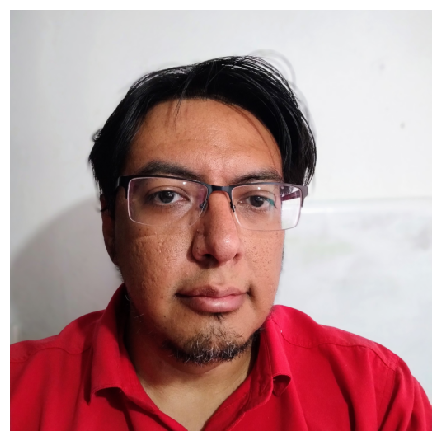

In [4]:
img = ski.util.img_as_float(ski.io.imread(img_path))
# Reescalar tamaño a 512x512
img = ski.transform.resize(img, (512, 512), anti_aliasing=True)

mostrar_imagen(img)

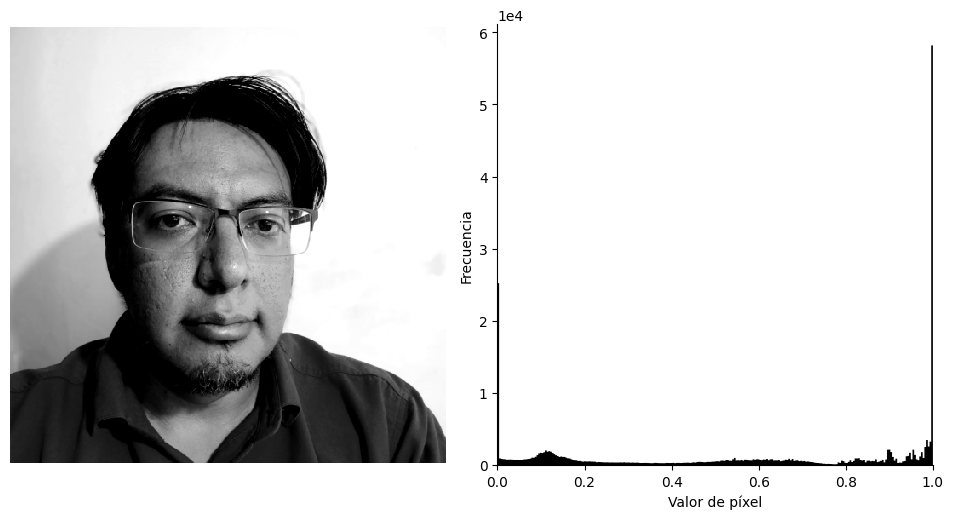

In [41]:
img_luz = ski.color.rgb2gray(img)
#img_luz = ski.exposure.equalize_hist(img_luz)
img_luz = ski.exposure.rescale_intensity(img_luz, in_range=(0.1, 0.9))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
mostrar_imagen(img_luz, axs[0])
mostrar_histograma(img_luz, axs[1])

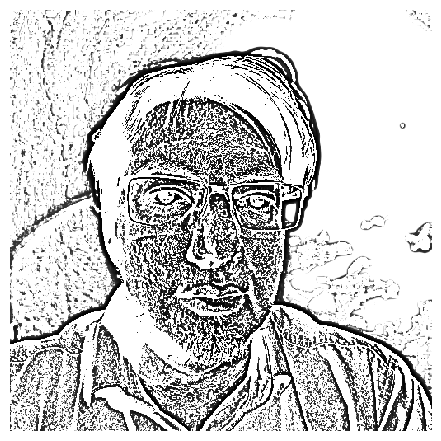

In [71]:
# Encontrar contornos mediante diferencia de gaussianas
img_contornos = ski.filters.difference_of_gaussians(img_luz, 0, 2)
img_contornos[img_contornos < 0] = 0

# Invertir imagen
img_contornos = 1 - img_contornos
img_contornos = ski.exposure.equalize_hist(img_contornos)

mostrar_imagen(img_contornos)

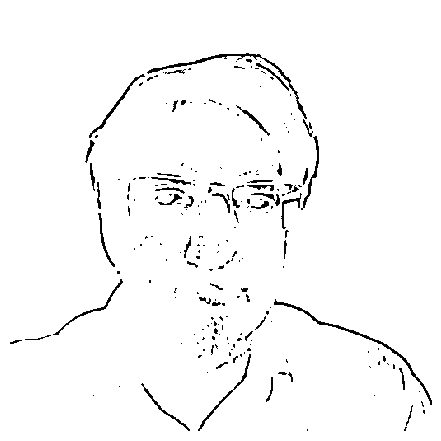

In [72]:

# Aplicar umbral
img_contornos[img_contornos > 0.05] = 1

# Aplicar un filtro de mediana
img_contornos = ski.filters.median(img_contornos, ski.morphology.disk(2))

# Mostrar imagen
mostrar_imagen(img_contornos)

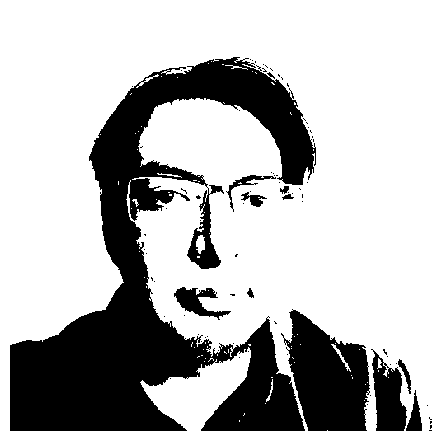

In [78]:
sombras = (img_luz >= np.quantile(img_luz, 0.3)).astype(float)

mostrar_imagen(sombras)

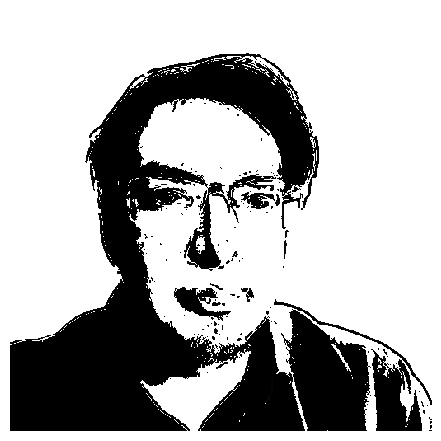

In [79]:
sombras *= img_contornos
#sombras = ski.filters.median(sombras, ski.morphology.disk(1))

mostrar_imagen(sombras)

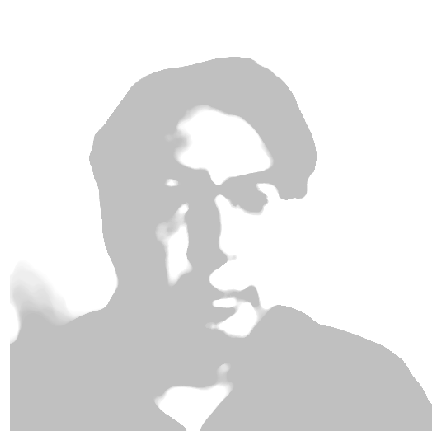

In [80]:
# Aplicar umbral
img_medios = 16*img_luz - 8
img_medios[img_medios < 0] = 0
img_medios[img_medios > 1] = 1

img_medios = img_medios/4 + 3/4  # Convertir a gris
img_medios = ski.filters.median(img_medios, ski.morphology.disk(8))

mostrar_imagen(img_medios)

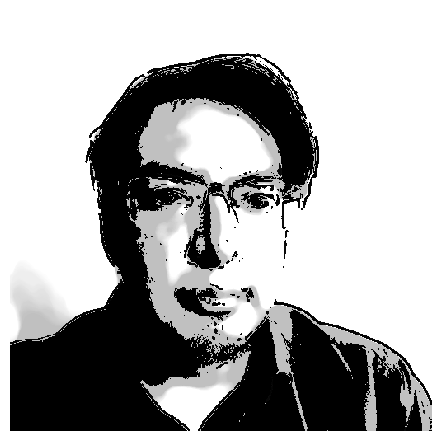

In [81]:
img_trazos = np.minimum(sombras, img_medios)

# img_trazos = ski.filters.gaussian(img_trazos, sigma=1)
# img_trazos = ski.filters.median(img_trazos, ski.morphology.disk(2))

mostrar_imagen(img_trazos)

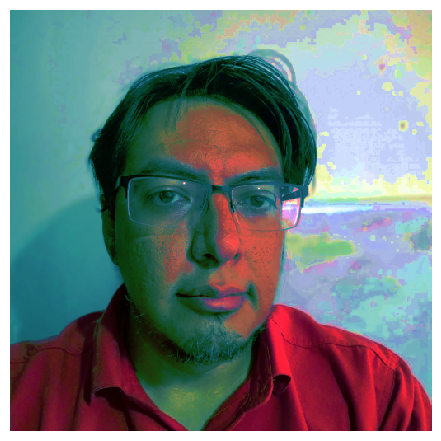

In [99]:
img_color = img.copy()
# Aplicar ecualización a cada canal
for i in range(3):
    img_color[:, :, i] = ski.exposure.equalize_hist(img_color[:, :, i])

# Incrementar la saturación
img_color = ski.color.rgb2hsv(img_color)
img_color[:, :, 1] **= 0.4
img_color = ski.color.hsv2rgb(img_color)

mostrar_imagen(img_color)

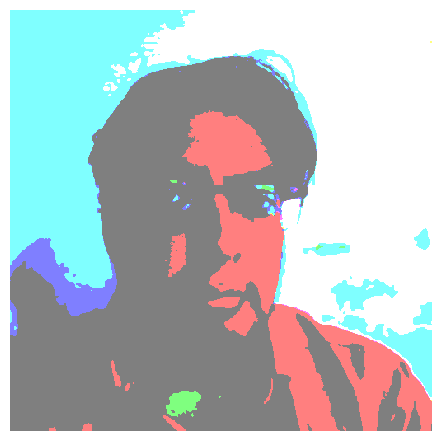

In [100]:
# Posterizar
img_color = ski.img_as_float(img_color)
img_color = np.ceil(img_color*2)/2

# Aplicar un filtro
# for i in range(3):
#     img_color[:, :, i] = ski.filters.gaussian(img_color[:, :, i], sigma=2)

for i in range(3):
    img_color[:, :, i] = ski.filters.median(img_color[:, :, i], ski.morphology.disk(2))

# Aplicar gamma
#img_color = ski.exposure.adjust_gamma(img_color, gamma=0.5)

mostrar_imagen(img_color)

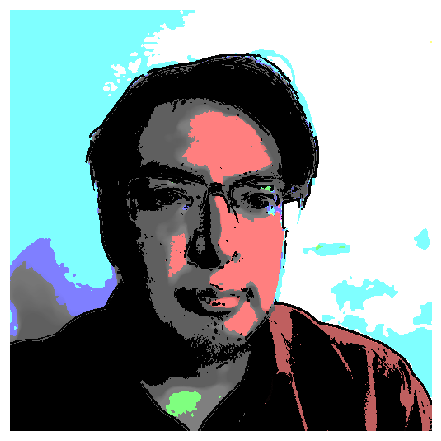

In [101]:
# Multiplicar cada capa de color RGB por la imagen de trazos
for ch in range(3):
    img_color[..., ch] *= img_trazos

mostrar_imagen(img_color)

In [ ]:
# Código completo para hacer el filtro

def convertir_a_comic(img, sigma_gauss=2, sigma_mediana=2):
    img_luz = ski.color.rgb2gray(img)
    img_luz = ski.exposure.equalize_hist(img_luz)

    img_contornos = ski.filters.difference_of_gaussians(img_luz, 0, 4)
    img_contornos[img_contornos < 0] = 0
    img_contornos = 1 - img_contornos
    img_contornos = ski.exposure.equalize_hist(img_contornos)
    img_contornos[img_contornos > 0.03] = 1

    sombras = (img_luz >= np.quantile(img_luz, 1/4)).astype(float)
    sombras *= img_contornos
    sombras = ski.filters.median(sombras, ski.morphology.disk(1))

    img_medios = 16*img_luz - 8
    img_medios[img_medios < 0] = 0
    img_medios[img_medios > 1] = 1
    img_medios = img_medios/8 + 7/8
    img_medios = ski.filters.median(img_medios, ski.morphology.disk(8))

    img_trazos = np.minimum(sombras, img_medios)

    img_color = img.copy()
    for i in range(3):
        img_color[:, :, i] = ski.exposure.equalize_hist(img_color[:, :, i])

    img_color = ski.color.rgb2hsv(img_color)
    img_color[:, :, 1] **= 0.4
    img_color = ski.color.hsv2rgb(img_color)

    for i in range(3):
        img_color[:, :, i] = ski.filters.gaussian(img_color[:, :, i], sigma=sigma_gauss)

    img_color = ski.exposure.adjust_gamma(img_color, gamma=0.5)
    img_color = ski.img_as_float(img_color)
    img_color = np.ceil(img_color*4)/4

    for ch in range(3):
        img_color[..., ch] *= img_trazos

    return img_color